In [93]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [94]:
# Read CSV file into DataFrame
df = pd.read_csv('/Users/tomifemme/Desktop/DataScience/Projeto/Forecasting/class_arrests_SMOTE.csv')



In [95]:
def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "CLASS"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: pd.DataFrame = pd.read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: pd.DataFrame = pd.read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

In [96]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from typing import Callable

CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}

In [97]:
from matplotlib.axes import Axes
def set_chart_labels(ax: Axes, title: str = "", xlabel: str = "", ylabel: str = "") -> Axes:
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

In [98]:
from datetime import datetime
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

def set_chart_xticks(xvalues: list[str | int | float | datetime], ax: Axes, percentage: bool = False) -> Axes:
    if len(xvalues) > 0:
        if percentage:
            ax.set_ylim(0.0, 1.0)

        if isinstance(xvalues[0], datetime):
            locator = AutoDateLocator()
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(AutoDateFormatter(locator, defaultfmt="%Y-%m-%d"))
        rotation: int = 0
        if not any(not isinstance(x, (int, float)) for x in xvalues):
            ax.set_xlim(left=xvalues[0], right=xvalues[-1])
            ax.set_xticks(xvalues, labels=xvalues)
        else:
            rotation = 45

        ax.tick_params(axis="x", labelrotation=rotation, labelsize="xx-small")

    return ax

In [99]:
def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(legend, fontsize="xx-small")
    return ax

In [100]:
DELTA_IMPROVE: float = 0.001

In [101]:
from matplotlib.pyplot import gca, gcf, savefig, subplots, text

In [102]:
def trees_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
    ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

Train#=12090 Test#=2653
Labels=[False, True]
DT best with gini and d=4


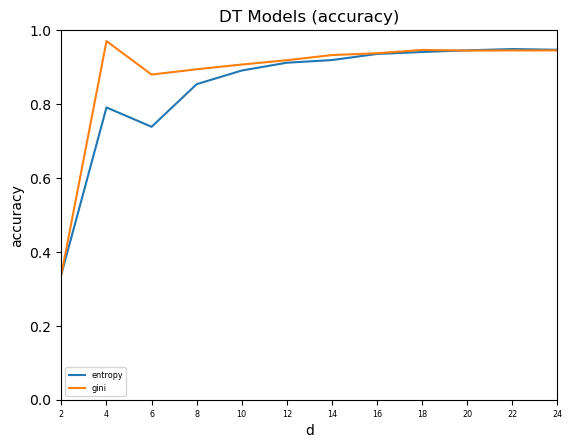

In [103]:
file_tag = 'arrests'
train_filename = '/Users/tomifemme/Desktop/DataScience/Projeto/Forecasting/class_arrests_SMOTE.csv'
test_filename = '/Users/tomifemme/Desktop/DataScience/Projeto/Forecasting/Arrests_testing_data.csv'
target = 'CLASS'
eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'{file_tag}_dt_{eval_metric}_study.png')
show()

In [104]:
from numpy import array, ndarray, arange, std, set_printoptions
from matplotlib.container import BarContainer
from matplotlib.font_manager import FontProperties
FONT_SIZE = 6
FONT_TEXT = FontProperties(size=FONT_SIZE)

In [105]:
def plot_multibar_chart(
    group_labels: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes | list[Axes]:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    bar_labels: list = list(yvalues.keys())

    # This is the location for each bar
    index: ndarray = arange(len(group_labels))
    bar_width: float = 0.8 / len(bar_labels)
    ax.set_xticks(index + bar_width / 2, labels=group_labels)

    for i in range(len(bar_labels)):
        bar_yvalues = yvalues[bar_labels[i]]
        values: BarContainer = ax.bar(
            index + i * bar_width,
            bar_yvalues,
            width=bar_width,
            label=bar_labels[i],
        )
        format = "%.2f" if percentage else "%.0f"
        ax.bar_label(values, fmt=format, fontproperties=FONT_TEXT)
        if any(y < 0 for y in bar_yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(fontsize="xx-small")
    return ax

In [106]:
from matplotlib.colors import LinearSegmentedColormap
from itertools import product
my_palette = {
    "yellow": "#ECD474",
    "pale orange": "#E9AE4E",
    "salmon": "#E2A36B",
    "orange": "#F79522",
    "dark orange": "#D7725E",
    "pale acqua": "#92C4AF",
    "acqua": "#64B29E",
    "marine": "#3D9EA9",
    "green": "#10A48A",
    "olive": "#99C244",
    "pale blue": "#BDDDE0",
    "blue2": "#199ED5",
    "blue3": "#1DAFE5",
    "dark blue": "#0C70B2",
    "pale pink": "#D077AC",
    "pink": "#EA4799",
    "lavender": "#E09FD5",
    "lilac": "#B081B9",
    "purple": "#923E97",
    "white": "#FFFFFF",
    "light grey": "#D2D3D4",
    "grey": "#939598",
    "black": "#000000",
    "red": "#FF0000"
}
blues = [
    my_palette["pale blue"],
    my_palette["blue2"],
    my_palette["blue3"],
    my_palette["dark blue"],
]
cmap_blues = LinearSegmentedColormap.from_list("myCMPBlues", blues)

In [107]:
def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cmap_blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center")
    return ax

In [108]:
HEIGHT: int = 4
from matplotlib.figure import Figure
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score
def plot_evaluation_results(model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs

<Figure size 640x480 with 0 Axes>

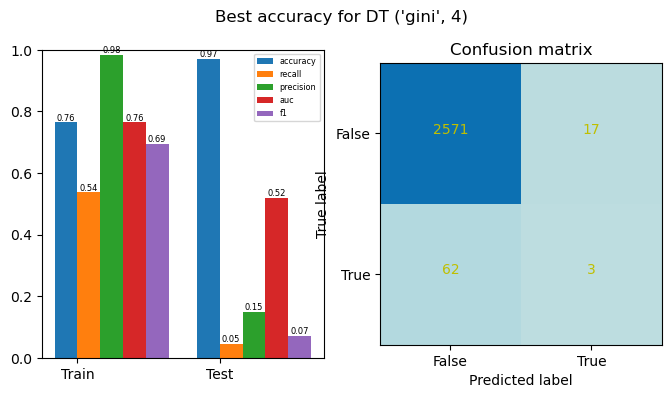

In [109]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

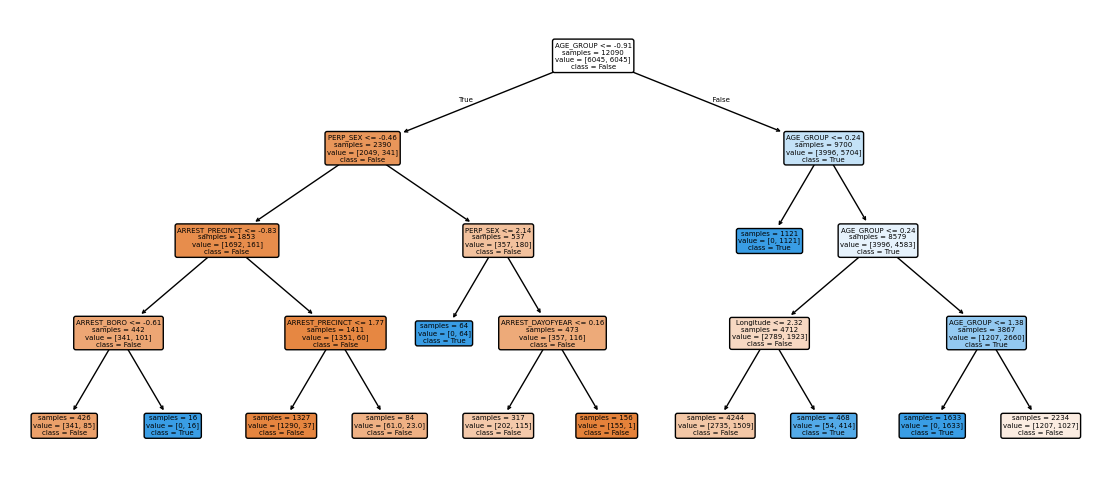

In [111]:
from sklearn.tree import plot_tree

tree_filename = 'decision_tree_plot'
max_depth2show = 5  # Set the max depth to show in the plot

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=[str(label) for label in labels],
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png")

In [112]:
def plot_horizontal_bar_chart(
    elements: list,
    values: list,
    error: list = [],
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    if percentage:
        ax.set_xlim((0, 1))
    if error == []:
        error = [0] * len(elements)
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    y_pos: list = list(arange(len(elements)))

    ax.barh(y_pos, values, xerr=error, align="center", error_kw={"lw": 0.5, "ecolor": "r"})
    ax.set_yticks(y_pos, labels=elements)
    ax.invert_yaxis()  # labels read top-to-bottom
    return ax

1. AGE_GROUP (0.8280565355637148)
2. Longitude (0.09420401776287471)
3. PERP_SEX (0.04613792811763313)
4. ARREST_PRECINCT (0.013110523808179843)
5. ARREST_DAYOFYEAR (0.010601496694624471)
6. ARREST_BORO (0.00788949805297288)
7. ARREST_DAYOFYEAR_cos (0.0)
8. ARREST_DAYOFYEAR_sin (0.0)
9. Latitude (0.0)
10. Y_COORD_CD (0.0)
11. X_COORD_CD (0.0)
12. PERP_RACE (0.0)
13. KY_CD (0.0)
14. PD_CD (0.0)


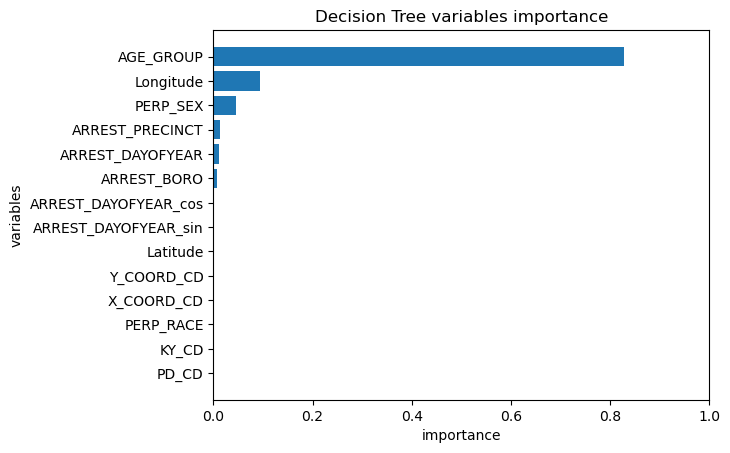

In [113]:
from numpy import argsort

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{file_tag}_dt_{eval_metric}_vars_ranking.png")

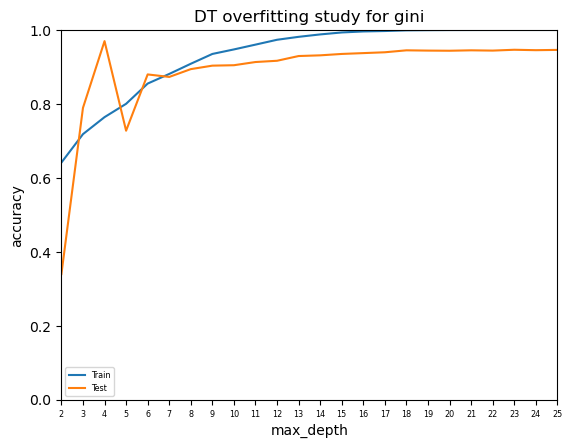

In [114]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{file_tag}_dt_{eval_metric}_overfitting.png")